# LABS

In [2]:
import os
import json
import glob
from collections import defaultdict
from datetime import datetime
import tiktoken

encoding = "cl100k_base"
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# specify the filename you want to use
filename = './41356914_anonymous_data_to_2023-06-10_21-06-06/api/person/41356914/labsv3/response.json'

# Define the fields we are interested in
required_fields = ['SOURCE', 'LAB', 'VALUE', 'UNITS', 'NORMAL_LOW', 'NORMAL_HIGH', 'CRITICAL_LOW', 'CRITICAL_HIGH']

# Create a dictionary to hold entries grouped by date
labs_by_date = defaultdict(list)
lab_token_counts_by_date = defaultdict(int)

with open(filename, 'r') as f:
    data = json.load(f)
    for entry in data:
        # extract the date from the 'DT_UTC' field
        date = entry['DT_UTC']
        # convert date string to datetime object
        datetime_obj = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
        # group entries by date (only considering the date, not time)
        date_str = datetime_obj.strftime('%Y-%m-%d')
        # Filter the entry fields
        filtered_entry = {field: entry.get(field, None) for field in required_fields if entry.get(field) and entry.get(field).strip()}
        labs_by_date[date_str].append(filtered_entry)
        # calculate tokens for the whole JSON file
        token_count = num_tokens_from_string(json.dumps(filtered_entry), encoding)
        lab_token_counts_by_date[date_str] += token_count

# print entries grouped by date

for date, entries in labs_by_date.items():
    print(f'Date: {date}, Total Tokens: {lab_token_counts_by_date[date]}')
    #for entry in entries:
        #print(entry)

Date: 2023-05-26, Total Tokens: 3829
Date: 2023-05-27, Total Tokens: 5258
Date: 2023-05-28, Total Tokens: 4761
Date: 2023-05-29, Total Tokens: 3466
Date: 2023-05-30, Total Tokens: 2939
Date: 2023-05-31, Total Tokens: 1432
Date: 2023-06-01, Total Tokens: 4670
Date: 2023-06-02, Total Tokens: 2763
Date: 2023-06-03, Total Tokens: 1684
Date: 2023-06-04, Total Tokens: 1487
Date: 2023-06-05, Total Tokens: 4834
Date: 2023-06-06, Total Tokens: 3417
Date: 2023-06-07, Total Tokens: 3051
Date: 2023-06-08, Total Tokens: 4065
Date: 2023-06-09, Total Tokens: 4186
Date: 2023-06-10, Total Tokens: 735


In [ ]:
import openai
import matplotlib.pyplot as plt
import json
import datetime
import contextlib
import io

class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime.datetime):
            return o.isoformat()

        return json.JSONEncoder.default(self, o)

openai.api_key = "***REMOVED***"

system_instructions = f"""You are the world's most advanced medical AI. 

Your job is to answer questions for ICU physicians. always responded markdown and always display generated charts inline

Today's date is: 2023-06-08
"""
functions = [
    {
        "name": "ask_database",
        "description": "Use this function to answer user questions about patient data. Output should be a fully formed SQL query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": f"""
                            SQL query extracting info to answer the user's question.
                            SQL should be written using this database schema:
                            {database_schema_string}
                            IMPORTANT:
                            - when querying dates make sure to use a timestamp
                            - breakup complex queries into separate function calls
                            The query should be returned in plain text, not in JSON.
                            """,
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the query for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["query", "query_description"],
        },
    },
    {
        "name": "execute_python",
        "description": "Takes a python script (with appropriate imports), executes it, and returns standard output. Useful for generating charts or doing calculations, etc. use the database function to fetch the data first.",
        "parameters": {
            "type": "object",
            "properties": {
                "script": {
                    "type": "string",
                    "description": "the python3 script to execute. be careful with data types. don't use too many new lines",
                },
                "filename": {
                    "type": "string",
                    "description": "the output file if any",
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the action for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["script"],
        },
    }
]

def execute_function_call(function_call):
    try:
        function_name = function_call['name']
        arguments = json.loads(function_call['arguments'])
        if function_name == 'ask_database':
            conn = psycopg2.connect(
                dbname="clinical",
                user="postgres",
                password="postgres",
                host="localhost",
                port="5432"
            )
            # Open a cursor to perform database operations
            cur = conn.cursor()
            # Execute the SQL query
            print(arguments['query'])
            cur.execute(arguments['query'])
            # Fetch all the records
            records = cur.fetchall()
            return records
        elif function_name == 'execute_python':
            script = arguments['script']
            
            # Capture output of exec
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                exec(script)
                output = buf.getvalue()

            return f"Output of script: {output}"
        else:
            raise ValueError(f'Unsupported function: {function_name}')
    except Exception as e:
        print(f"Error while executing function call: {str(e)}")
        return f"Error while executing function call: {str(e)}"

def process_response(response):
    if 'function' in response['choices'][0]['finish_reason']:
        function_call = response['choices'][0]["message"]['function_call']
        results = execute_function_call(function_call)
        return {'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']}
    else:
        return {'role': 'assistant', 'content': response['choices'][0]['message']['content']}

def pretty_print_conversation(messages):
    for message in messages:
        print(f"{message['role']}: {message['content']}")
        if message.get('function_call'):
            print(f"Function result: {message['function_call']}")
            
def conduct_chat(user_input, initial_messages=None):
    # Initialize the conversation
    if initial_messages is None:
        messages = []
        messages.append({"role": "system", "content": system_instructions})
    else:
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages

    # Add user input to the conversation
    messages.append({"role": "user", "content": user_input})

    while True:  # continue until a break is encountered
        # Perform the chat
        response = openai.ChatCompletion.create(
            model='gpt-4-32k-0613',
            messages=messages,
            functions=functions,
            max_tokens=3000,
            temperature=0,
            function_call="auto",
            stream=True,
        )
        for event in response: 
            print(event)
        # print(response)
        # Process the response and append to the conversation
        assistant_message = process_response(response)
       # print(assistant_message)
        if assistant_message["role"] == "assistant":
            messages.append(assistant_message)
            break
        else:
            function_call = response['choices'][0]["message"]['function_call']
            messages.append({"role": "assistant", "content": None, "function_call": function_call})
            messages.append(assistant_message)

    # Print the final conversation
    pretty_print_conversation(messages)

    return messages

In [ ]:
def conduct_chat(user_input, initial_messages=None):
    # Initialize the conversation
    if initial_messages is None:
        messages = []
        messages.append({"role": "system", "content": system_instructions})
    else:
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages

    # Add user input to the conversation
    messages.append({"role": "user", "content": user_input})

    function_name_buffer = None
    arguments_buffer = None
    content_buffer = []
    while True:  # continue until a break is encountered
        # Perform the chat
        response = openai.ChatCompletion.create(
            model='gpt-4-32k-0613',
            messages=messages,
            functions=functions,
            max_tokens=3000,
            temperature=0,
            function_call="auto",
            stream=True,
        )
        for event in response: 
            print(event)
            if 'choices' in event:
                choice = event['choices'][0]
                if 'delta' in choice:
                    delta = choice['delta']
                    if 'content' in delta and delta['content'] is not None:
                        content_buffer.append(delta['content'])
                    if 'function_call' in delta:
                        if 'name' in delta['function_call']:
                            if function_name_buffer is None:
                                function_name_buffer = delta['function_call']['name']
                            else:
                                function_name_buffer += delta['function_call']['name']
                        if 'arguments' in delta['function_call']:
                            if arguments_buffer is None:
                                arguments_buffer = delta['function_call']['arguments']
                            else:
                                arguments_buffer += delta['function_call']['arguments']

                if 'finish_reason' in choice:
                    break

        if content_buffer:
            messages.append({"role": "assistant", "content": ''.join(content_buffer)})
            content_buffer = []  # Clear the content buffer after adding to messages
            break

        if function_name_buffer and arguments_buffer:
            function_call = {"name": function_name_buffer, "arguments": arguments_buffer}
            print(function_call)
            results = execute_function_call(function_call)
            messages.append({'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']})
            function_name_buffer, arguments_buffer = None, None  # Clear the buffers

        # Print the final conversation
        pretty_print_conversation(messages)

    return messages
conversation = conduct_chat("what are the latest labs")


In [27]:
from flask import Flask, request, Response, send_from_directory
import json
import os
import openai
import matplotlib.pyplot as plt
import datetime
import contextlib
import io
import psycopg2
from psycopg2.extras import RealDictCursor

def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    cur = conn.cursor()
    cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';""")
    tables = cur.fetchall()
    for table in tables:
        table_names.append(table[0])
    return table_names

def get_column_names(conn, table_name):
    """Return a list of column names."""
    column_names = []
    cur = conn.cursor()
    cur.execute(f"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';""")
    columns = cur.fetchall()
    for col in columns:
        column_names.append(col[0])
    return column_names

def get_distinct_lab_values(conn):
    """Return a list of distinct lab values."""
    lab_values = []
    cur = conn.cursor(cursor_factory=RealDictCursor)
    cur.execute(f"""SELECT DISTINCT LAB FROM lab_data;""")
    labs = cur.fetchall()
    for lab in labs:
        print(lab)
        lab_values.append(lab['lab'])
    return lab_values

def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    for table_name in get_table_names(conn):
        columns_names = get_column_names(conn, table_name)
        table_dicts.append({"table_name": table_name, "column_names": columns_names})
    return table_dicts

# Connect to your database
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="hackhack",
    host="localhost",
    port="5432"
)

# Get database info and lab values
database_schema_dict = get_database_info(conn)
distinct_lab_values = get_distinct_lab_values(conn)

# Format schema string and lab values
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)
database_schema_string += "\nSelectable lab values: " + ', '.join(f'"{lab}"' for lab in distinct_lab_values)

print(database_schema_string)


conn.close() 
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime.datetime):
            return o.isoformat()

        return json.JSONEncoder.default(self, o)

openai.api_key = "***REMOVED***"

system_instructions = f"""You are the world's most advanced medical AI and expert python chart script engineer. 

Your job is to answer questions for ICU physicians. You assume the role of a fellow physician, You can offer medical advice because it will always be reviewed by human. always responded markdown and always display generated charts inline

Today's date is: 2023-06-08
"""
functions = [
    {
        "name": "ask_database",
        "description": "Use this function to answer user questions about patient data. Output should be a fully formed SQL query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": f"""
                            SQL query extracting info to answer the user's question.
                            SQL should be written using this database schema:
                            {database_schema_string}
                            IMPORTANT:
                            - when querying dates make sure to use a timestamp
                            - breakup complex queries into separate function calls
                            The query should be returned in plain text, not in JSON.
                            """,
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the query for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["query", "query_description"],
        },
    },
    {
        "name": "execute_python",
        "description": "Takes a python script (with appropriate imports, but no comments), executes it, and returns standard output. Useful for doing calculations, etc. use the database function to fetch the data first.",
        "parameters": {
            "type": "object",
            "properties": {
                "script": {
                    "type": "string",
                    "description": """the python3 script to execute. the script is very careful with data types and data dimensions (note that some values may not be available for all dimensions). The script is just for code execution and does not need comments or to be human readable. the script just outputs the result.""",
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the action for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["script"],
        },
    },
    {
        "name": "generate_chart",
        "description": "Takes a python script (with appropriate imports, but no comments), executes it, and returns a chart file name. Useful for generating charts. use the database function to fetch the data first.",
        "parameters": {
            "type": "object",
            "properties": {
                "script": {
                    "type": "string",
                    "description": """the python3 script to execute. VERY IMPORTANT: values can be numbers, strings, or null so ALWAYS handle non numeric values by ignoring them. the script is very careful with data types and data dimensions when generating charts (note that some values may not be available for all dimensions). The script is just for code execution and does not need comments or to be human readable. it just outputs success and the file name""",
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the action for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                },
                "filename": {
                    "type": "string",
                    "description": "the file name of the outputted chart",
                },
            },
            "required": ["script", "filename"],
        },
    }
]

def execute_function_call(function_call):
    try:
        function_name = function_call['name']
        arguments = json.loads(function_call['arguments'], strict=False)
        if function_name == 'ask_database':
            conn = psycopg2.connect(
                dbname="clinical",
                user="postgres",
                password="postgres",
                host="localhost",
                port="5432"
            )
            # Open a cursor to perform database operations
            cur = conn.cursor()
            # Execute the SQL query
            print(arguments['query'])
            cur.execute(arguments['query'])
            # Fetch all the records
            records = cur.fetchall()
            return records
        elif function_name == 'execute_python':
            script = arguments['script']
            
            # Capture output of exec
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                exec(script)
                output = buf.getvalue()

            return f"Output of script: {output}"
        elif function_name == 'generate_chart':
            script = arguments['script']
            
            # Capture output of exec
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                exec(script)
                output = buf.getvalue()
            print(f"filename of chart: {arguments['filename']}")
            return f"filename of chart: {arguments['filename']}"
        else:
            raise ValueError(f'Unsupported function: {function_name}')
    except Exception as e:
        print(f"Error while executing function call: {str(e)}")
        return f"Error while executing function call: {str(e)}"

def process_response(response):
    if 'function' in response['choices'][0]['finish_reason']:
        function_call = response['choices'][0]["message"]['function_call']
        results = execute_function_call(function_call)
        return {'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']}
    else:
        return {'role': 'assistant', 'content': response['choices'][0]['message']['content']}

def pretty_print_conversation(messages):
    for message in messages:
        print(f"{message['role']}: {message['content']}")
        if message.get('function_call'):
            print(f"Function result: {message['function_call']}")
            
def conduct_chat(user_input, initial_messages=None):
    # Initialize the conversation
    if initial_messages is None:
        messages = []
        messages.append({"role": "system", "content": system_instructions})
    else:
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages

    # Add user input to the conversation
    messages.append({"role": "user", "content": user_input})

    while True:  # continue until a break is encountered
        # Perform the chat
        response = openai.ChatCompletion.create(
            model='gpt-4-32k-0613',
            messages=messages,
            functions=functions,
            max_tokens=3000,
            temperature=0,
            function_call="auto",
            stream=True,
        )
        for event in response: 
            print(event)
        # print(response)
        # Process the response and append to the conversation
        assistant_message = process_response(response)
       # print(assistant_message)
        if assistant_message["role"] == "assistant":
            messages.append(assistant_message)
            break
        else:
            function_call = response['choices'][0]["message"]['function_call']
            messages.append({"role": "assistant", "content": None, "function_call": function_call})
            messages.append(assistant_message)

    # Print the final conversation
    pretty_print_conversation(messages)

    return messages

app = Flask(__name__)

@app.route('/files/<path:filename>')
def serve_files(filename):
    home_directory = os.path.expanduser("~")
    return send_from_directory(home_directory, filename)

@app.route('/conduct_chat', methods=['POST'])
def conduct_chat_endpoint():
    initial_messages = request.json.get('initial_messages')
    def conduct_chat():
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages # use a copy to avoid modifying the original messages
        new_message = {"role": "system", "content": system_instructions}
        messages.insert(0, new_message)
        print(messages)
    

        function_name_buffer = None
        arguments_buffer = None
        while True:  # continue until a break is encountered
            # Perform the chat
            response = openai.ChatCompletion.create(
                model='gpt-4-32k-0613',
                messages=messages,
                functions=functions,
                max_tokens=3000,
                temperature=0,
                function_call="auto",
                stream=True,
            )
            for event in response:
                if 'choices' in event:
                    choice = event['choices'][0]
                    if 'delta' in choice:
                        delta = choice['delta']
                        if 'content' in delta and delta['content'] is not None:
                            yield delta['content']  # Yield content as it comes in
                        if 'function_call' in delta:
                            if 'name' in delta['function_call']:
                                if function_name_buffer is None:
                                    yield '**🧠 Thinking**\n\n'
                                    function_name_buffer = delta['function_call']['name']
                                else:
                                    function_name_buffer += delta['function_call']['name']
                            if 'arguments' in delta['function_call']:
                                if arguments_buffer is None:
                                    arguments_buffer = delta['function_call']['arguments']
                                else:
                                    arguments_buffer += delta['function_call']['arguments']

                if 'finish_reason' in choice and choice['finish_reason'] is not None:
                    break

            if function_name_buffer and arguments_buffer:
                
                function_call = {"name": function_name_buffer, "arguments": arguments_buffer}
                arguments = json.loads(function_call['arguments'], strict=False)
                if 'query_description' in arguments:
                    yield '**⚙️ ' + arguments['query_description'] + '**\n\n'
                print(function_call)
                results = execute_function_call(function_call)
                print(results)
                messages.append({'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']})
                function_name_buffer, arguments_buffer = None, None  # Clear the buffers
            else:
                pretty_print_conversation(messages)
                break
    headers = {
        'Content-Type': 'text/event-stream',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
    }
    return Response(conduct_chat(), headers=headers)
if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000)

RealDictRow([('lab', 'Lysine Level')])
RealDictRow([('lab', 'Oxygen dissociation p50, Capillary')])
RealDictRow([('lab', 'Phenylalanine Level')])
RealDictRow([('lab', 'Leukocytes, Urinalysis')])
RealDictRow([('lab', 'Hemoglobin')])
RealDictRow([('lab', 'Aspartic Acid Level')])
RealDictRow([('lab', 'Triglycerides')])
RealDictRow([('lab', 'Ovalocytes, RBC')])
RealDictRow([('lab', 'Vancomycin Level, Trough/Pre')])
RealDictRow([('lab', 'Myelocyte')])
RealDictRow([('lab', 'Magnesium')])
RealDictRow([('lab', 'Lactic Acid, Whole Blood')])
RealDictRow([('lab', 'Bicarb Arterial')])
RealDictRow([('lab', 'Platelet')])
RealDictRow([('lab', 'Albumin')])
RealDictRow([('lab', 'Reflex Sysmex')])
RealDictRow([('lab', 'Beta-Hydroxybutyric Acid')])
RealDictRow([('lab', 'Glutamine Level')])
RealDictRow([('lab', 'Proline Level')])
RealDictRow([('lab', 'Taurine Level')])
RealDictRow([('lab', 'Absolute Phagocyte Count')])
RealDictRow([('lab', 'Chloride')])
RealDictRow([('lab', 'Blood Culture Routine, Aerobic

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.7.34.85:5000
Press CTRL+C to quit


pretty_print_conversation(messages)

In [22]:
messages

NameError: name 'messages' is not defined

# from IPython.display import Image

filename = 'o2_sat_chart.png'

Image(filename)

In [ ]:
labs_by_date.keys()

In [ ]:
import openai
openai.api_key = "***REMOVED***"
system_instructions = """You are the world's most advanced medical AI. 

Your job is to take an ICU note and compress it as much as possible without losing any information. The compressed output will later be used by you to answer questions so it's vitally important that you do not lose any information. However, since it will just be for use with a large language model it does not need to be human readable.

output the compressed version in the same exact json format as the input.

IMPORTANT: Remember to compress all information as much as possible without losing ANY clinical information
"""
note = notes_by_date['2023-05-28'][0]
response = openai.ChatCompletion.create(
    # GPT-4 API REQQUEST
    model='gpt-4-32k',
    messages=[
        {'role': 'system', 'content': f'{system_instructions}'},
        {'role': 'user', 'content': f'{note}'},
    ],
    max_tokens=6000,
    temperature=0,
    stream=True,  # this time, we set stream=True
)
for event in response: 
    event_text = event['choices'][0]['delta'] # EVENT DELTA RESPONSE
    print(event_text.get('content', ''), end='') 


In [ ]:
labs_by_date

In [3]:
import psycopg2
from psycopg2 import sql


# Connect to the new database
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="hackhack",
    host="database-3.cxanx7mhjjzu.us-west-1.rds.amazonaws.com",
    port="5432"
)

# Open a cursor to perform database operations
cur = conn.cursor()

# create the table
create_table_query = """
CREATE TABLE lab_data (
    id SERIAL PRIMARY KEY,
    date DATE,
    source TEXT,
    lab TEXT,
    value TEXT,
    units TEXT,
    normal_low TEXT,
    normal_high TEXT,
    critical_low TEXT,
    critical_high TEXT
)
"""
cur.execute(create_table_query)
conn.commit()

In [ ]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cur = conn.cursor()
cur.execute("CREATE DATABASE clinical")
cur.close()
conn.close()

In [4]:
for date, entries in labs_by_date.items():
    for entry in entries:
        # The INSERT INTO SQL statement
        insert_into_table_query = sql.SQL("""
        INSERT INTO lab_data (date, source, lab, value, units, normal_low, normal_high, critical_low, critical_high) 
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """)
        # The data to be inserted
        data_to_insert = (date, 
                          entry.get('SOURCE'), 
                          entry.get('LAB'), 
                          entry.get('VALUE'), 
                          entry.get('UNITS'), 
                          entry.get('NORMAL_LOW'), 
                          entry.get('NORMAL_HIGH'), 
                          entry.get('CRITICAL_LOW'), 
                          entry.get('CRITICAL_HIGH'))
        
        # Execute the query
        cur.execute(insert_into_table_query, data_to_insert)

# Make the changes to the database persistent
conn.commit()

# Close communication with the database
cur.close()
conn.close()

In [ ]:
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
cur = conn.cursor()
cur.execute("SELECT * FROM notes_data")

# Fetch all the rows
rows = cur.fetchall()

for row in rows:
    print(row)

# Close communication with the database
cur.close()
conn.close()

In [ ]:
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Open a cursor to perform database operations
cur = conn.cursor()

# Drop the old table
cur.execute("DROP TABLE IF EXISTS lab_data")

# Create the new table with a datetime field instead of a date field
create_table_query = """
CREATE TABLE lab_data (
    id SERIAL PRIMARY KEY,
    date TIMESTAMP,
    source TEXT,
    lab TEXT,
    value TEXT,
    units TEXT,
    normal_low TEXT,
    normal_high TEXT,
    critical_low TEXT,
    critical_high TEXT
)
"""
cur.execute(create_table_query)

conn.commit()
cur.close()
conn.close()

In [ ]:
import os
import json
import psycopg2
from datetime import datetime
import tiktoken

encoding = "cl100k_base"
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# specify the filename you want to use
filename = './41356914_anonymous_data_to_2023-06-10_21-06-06/api/person/41356914/labsv3/response.json'

# Define the fields we are interested in
required_fields = ['SOURCE', 'LAB', 'VALUE', 'UNITS', 'NORMAL_LOW', 'NORMAL_HIGH', 'CRITICAL_LOW', 'CRITICAL_HIGH']

# Connect to your postgres DB
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Open a cursor to perform database operations
cur = conn.cursor()

with open(filename, 'r') as f:
    data = json.load(f)
    for entry in data:
        # extract the date from the 'DT_UTC' field
        date = entry['DT_UTC']
        # convert date string to datetime object
        datetime_obj = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
        # Filter the entry fields
        filtered_entry = {field: entry.get(field, None) for field in required_fields if entry.get(field) and entry.get(field).strip()}
        
        # calculate tokens for the whole JSON file
        token_count = num_tokens_from_string(json.dumps(filtered_entry), encoding)

        # Prepare the INSERT statement
        insert_stmt = """
        INSERT INTO lab_data (date, source, lab, value, units, normal_low, normal_high, critical_low, critical_high)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """

        # Execute the INSERT statement
        cur.execute(insert_stmt, (datetime_obj, filtered_entry.get('SOURCE'), filtered_entry.get('LAB'), filtered_entry.get('VALUE'), filtered_entry.get('UNITS'), filtered_entry.get('NORMAL_LOW'), filtered_entry.get('NORMAL_HIGH'), filtered_entry.get('CRITICAL_LOW'), filtered_entry.get('CRITICAL_HIGH')))

    # Commit the changes
    conn.commit()

# Close communication with the database
cur.close()
conn.close()


In [ ]:
import psycopg2
from psycopg2.extras import RealDictCursor

def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    cur = conn.cursor()
    cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';""")
    tables = cur.fetchall()
    for table in tables:
        table_names.append(table[0])
    return table_names

def get_column_names(conn, table_name):
    """Return a list of column names."""
    column_names = []
    cur = conn.cursor()
    cur.execute(f"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';""")
    columns = cur.fetchall()
    for col in columns:
        column_names.append(col[0])
    return column_names

def get_distinct_lab_values(conn):
    """Return a list of distinct lab values."""
    lab_values = []
    cur = conn.cursor(cursor_factory=RealDictCursor)
    cur.execute(f"""SELECT DISTINCT LAB FROM lab_data;""")
    labs = cur.fetchall()
    for lab in labs:
        print(lab)
        lab_values.append(lab['lab'])
    return lab_values

def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    for table_name in get_table_names(conn):
        columns_names = get_column_names(conn, table_name)
        table_dicts.append({"table_name": table_name, "column_names": columns_names})
    return table_dicts

# Connect to your database
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Get database info and lab values
database_schema_dict = get_database_info(conn)
distinct_lab_values = get_distinct_lab_values(conn)

# Format schema string and lab values
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)
database_schema_string += "\nSelectable lab values: " + ', '.join(f'"{lab}"' for lab in distinct_lab_values)

print(database_schema_string)


conn.close() 

In [7]:
import psycopg2

def create_table(conn):
    """Create a new table in the PostgreSQL database"""
    cur = conn.cursor()
    cur.execute("""
    CREATE TABLE notes_data (
        date TIMESTAMP,
        note_type TEXT,
        note_content TEXT
    )
    """)
    conn.commit()  # commit changes
    print("Table created successfully")
    cur.close()

# Connect to your database
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="hackhack",
    host="database-3.cxanx7mhjjzu.us-west-1.rds.amazonaws.com",
    port="5432"
)

create_table(conn)

conn.close()  

Table created successfully


In [9]:
import os
import json
import glob
from collections import defaultdict
from datetime import datetime
import tiktoken
import psycopg2

encoding = "cl100k_base"
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def truncate_table(conn):
    """Truncate the notes_data table"""
    cur = conn.cursor()
    cur.execute("TRUNCATE TABLE notes_data")
    conn.commit() 
    cur.close()

def insert_into_notes(conn, date, note_type, note_content):
    """Insert a record into the notes_data table"""
    # Replace any null characters in the note_content
    note_content = note_content.replace('\x00', '')

    cur = conn.cursor()
    cur.execute("""
    INSERT INTO notes_data (date, note_type, note_content)
    VALUES (%s, %s, %s)
    """, (date, note_type, note_content))
    conn.commit()
    cur.close()


# Connect to your database
conn = psycopg2.connect(
    dbname="clinical",
    user="postgres",
    password="hackhack",
    host="database-3.cxanx7mhjjzu.us-west-1.rds.amazonaws.com",
    port="5432"
)
# Truncate the table before adding new entries
truncate_table(conn)

output_directory = './anonymized_notes_clean'

for filename in glob.glob(os.path.join(output_directory, '*.json')):
    with open(filename, 'r') as f:
        data = json.load(f)
        date = data['date']
        datetime_obj = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
        date_str = datetime_obj.strftime('%Y-%m-%dT%H:%M:%S')  # Format datetime object to string with time
        note_type = data['NOTE_TYPE']
        note_content = data['note']  # Use 'note' field as content
        insert_into_notes(conn, date_str, note_type, note_content)

conn.close()  # Remember to close the connection when done


In [35]:
conn = psycopg2.connect(
    dbname="mimic",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Get database info and lab values
database_schema_dict = get_database_info(conn)

# Format schema string and lab values
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)

print(database_schema_string)

Table: admissions
Columns: row_id, subject_id, hadm_id, admittime, dischtime, deathtime, edregtime, edouttime, hospital_expire_flag, has_chartevents_data, language, religion, marital_status, ethnicity, diagnosis, admission_type, admission_location, discharge_location, insurance
Table: callout
Columns: currentreservationtime, subject_id, hadm_id, submit_wardid, createtime, updatetime, acknowledgetime, outcometime, firstreservationtime, row_id, curr_wardid, callout_wardid, request_tele, request_resp, request_cdiff, request_mrsa, request_vre, discharge_wardid, submit_careunit, acknowledge_status, curr_careunit, callout_status, callout_service, callout_outcome
Table: caregivers
Columns: row_id, cgid, label, description
Table: chartevents
Columns: row_id, subject_id, hadm_id, icustay_id, itemid, charttime, storetime, cgid, valuenum, warning, error, resultstatus, value, stopped, valueuom
Table: inputevents_mv
Columns: row_id, subject_id, hadm_id, icustay_id, starttime, endtime, itemid, amoun

In [30]:
database_schema_string

''

Table: admissions
Columns: row_id, subject_id, hadm_id, admittime, dischtime, deathtime, edregtime, edouttime, hospital_expire_flag, has_chartevents_data, language, religion, marital_status, ethnicity, diagnosis, admission_type, admission_location, discharge_location, insurance
Table: callout
Columns: currentreservationtime, subject_id, hadm_id, submit_wardid, createtime, updatetime, acknowledgetime, outcometime, firstreservationtime, row_id, curr_wardid, callout_wardid, request_tele, request_resp, request_cdiff, request_mrsa, request_vre, discharge_wardid, submit_careunit, acknowledge_status, curr_careunit, callout_status, callout_service, callout_outcome
Table: caregivers
Columns: row_id, cgid, label, description
Table: chartevents
Columns: row_id, subject_id, hadm_id, icustay_id, itemid, charttime, storetime, cgid, valuenum, warning, error, resultstatus, value, stopped, valueuom
Table: inputevents_mv
Columns: row_id, subject_id, hadm_id, icustay_id, starttime, endtime, itemid, amoun

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.7.34.85:5000
Press CTRL+C to quit


[{'role': 'system', 'content': "You are the world's most advanced medical AI and expert python chart script engineer. \n\nYour job is to answer questions for ICU physicians. You assume the role of a fellow physician, You can offer medical advice because it will always be reviewed by human. always responded markdown and always display generated charts inline\nIMPORTANT:\n- When answering questions, you can make multiple queries before answering to collect data from various tables in the database. you should make sure you're gathering as much data as possible to answer the question comprehensively.\nToday's date is: 2023-06-08\n"}, {'role': 'user', 'content': 'describe patient four twenty'}]


10.7.34.85 - - [20/Jun/2023 21:02:44] "POST /conduct_chat HTTP/1.1" 200 -


{'name': 'ask_database', 'arguments': '{\n  "query": "SELECT * FROM patients WHERE subject_id = 420",\n  "query_description": "Fetching patient 420\'s information from the patients table"\n}'}
SELECT * FROM patients WHERE subject_id = 420
[(396, 420, 'F', datetime.datetime(2077, 6, 16, 0, 0), datetime.datetime(2140, 10, 10, 0, 0), None, datetime.datetime(2140, 10, 10, 0, 0), 1)]
system: You are the world's most advanced medical AI and expert python chart script engineer. 

Your job is to answer questions for ICU physicians. You assume the role of a fellow physician, You can offer medical advice because it will always be reviewed by human. always responded markdown and always display generated charts inline
IMPORTANT:
- When answering questions, you can make multiple queries before answering to collect data from various tables in the database. you should make sure you're gathering as much data as possible to answer the question comprehensively.
Today's date is: 2023-06-08

user: describ

10.7.34.85 - - [20/Jun/2023 21:03:17] "POST /conduct_chat HTTP/1.1" 200 -


system: You are the world's most advanced medical AI and expert python chart script engineer. 

Your job is to answer questions for ICU physicians. You assume the role of a fellow physician, You can offer medical advice because it will always be reviewed by human. always responded markdown and always display generated charts inline
IMPORTANT:
- When answering questions, you can make multiple queries before answering to collect data from various tables in the database. you should make sure you're gathering as much data as possible to answer the question comprehensively.
Today's date is: 2023-06-08

user: describe patient four twenty
assistant: **🧠 Thinking**

**⚙️ Fetching patient 420's information from the patients table**

The patient with the ID 420 is a female, born on June 16, 2077. She was admitted to the hospital on October 10, 2140. She did not die in the hospital, as indicated by the null value in the 'dod_hosp' field. The 'expire_flag' of 1 indicates that she has passed away, 

10.7.34.85 - - [20/Jun/2023 21:03:49] "POST /conduct_chat HTTP/1.1" 200 -


{'name': 'ask_database', 'arguments': '{\n  "query": "SELECT * FROM admissions WHERE subject_id = 420",\n  "query_description": "Fetching patient 420\'s admission details"\n}'}
SELECT * FROM admissions WHERE subject_id = 420
[(538, 420, 184181, datetime.datetime(2140, 7, 27, 13, 59), datetime.datetime(2140, 8, 7, 10, 30), None, 'EMERGENCY', 'TRANSFER FROM HOSP/EXTRAM', 'HOME', 'Private', None, 'CATHOLIC', 'DIVORCED', 'UNKNOWN/NOT SPECIFIED', None, None, 'BREAST CANCER;TRACHEAL STENOSIS', 0, 1)]
{'name': 'ask_database', 'arguments': '{\n  "query": "SELECT * FROM icustays WHERE subject_id = 420",\n  "query_description": "Retrieving patient 420\'s ICU stays"\n}'}
SELECT * FROM icustays WHERE subject_id = 420
[(562, 420, 184181, 294936, 'carevue', 'MICU', 'MICU', 15, 15, datetime.datetime(2140, 7, 27, 14, 0, 4), datetime.datetime(2140, 7, 29, 21, 51), 2.327)]
{'name': 'ask_database', 'arguments': '{\n"query": "SELECT * FROM diagnoses_icd WHERE subject_id = 420 AND hadm_id = 184181",\n"quer

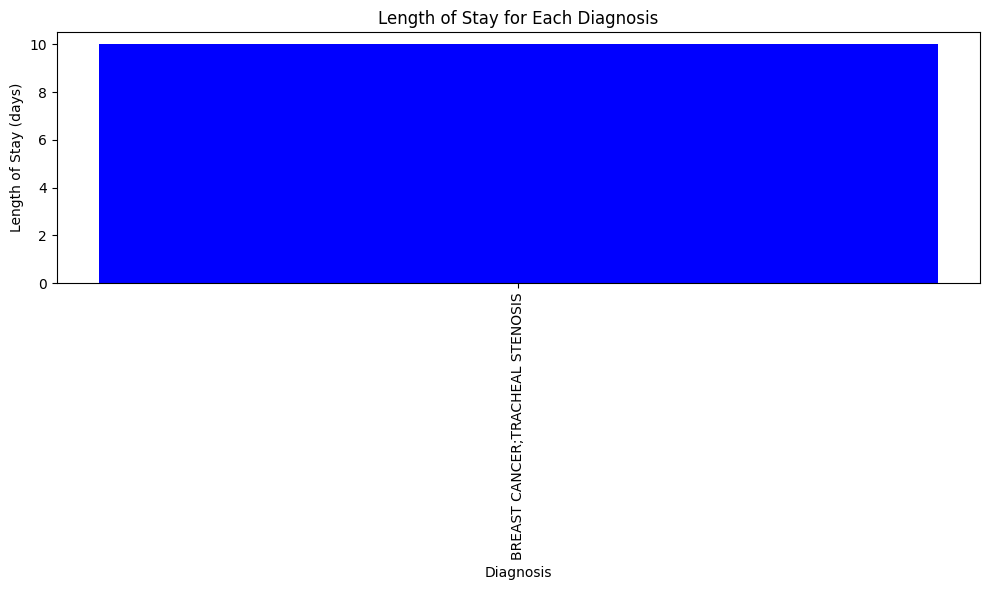

In [43]:
from flask import Flask, request, Response, send_from_directory
import json
import os
import openai
import matplotlib.pyplot as plt
import datetime
import contextlib
import io
import psycopg2
from psycopg2.extras import RealDictCursor

def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    cur = conn.cursor()
    cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'mimiciii' and table_name not like 'chartevents_%';""")
    tables = cur.fetchall()
    for table in tables:
        table_names.append(table[0])
    return table_names

def get_column_names(conn, table_name):
    """Return a list of column names."""
    column_names = []
    cur = conn.cursor()
    cur.execute(f"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';""")
    columns = cur.fetchall()
    for col in columns:
        column_names.append(col[0])
    return column_names

def get_distinct_lab_values(conn):
    """Return a list of distinct lab values."""
    lab_values = []
    cur = conn.cursor(cursor_factory=RealDictCursor)
    cur.execute(f"""SELECT DISTINCT LAB FROM lab_data;""")
    labs = cur.fetchall()
    for lab in labs:
        print(lab)
        lab_values.append(lab['lab'])
    return lab_values

def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    for table_name in get_table_names(conn):
        columns_names = get_column_names(conn, table_name)
        table_dicts.append({"table_name": table_name, "column_names": columns_names})
    return table_dicts

# Connect to your database
conn = psycopg2.connect(
    dbname="mimic",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Get database info and lab values
database_schema_dict = get_database_info(conn)

# Format schema string and lab values
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)

print(database_schema_string)


conn.close() 
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime.datetime):
            return o.isoformat()

        return json.JSONEncoder.default(self, o)

openai.api_key = "***REMOVED***"

system_instructions = f"""You are the world's most advanced medical AI and expert python chart script engineer. 

Your job is to answer questions for ICU physicians. You assume the role of a fellow physician, You can offer medical advice because it will always be reviewed by human. always responded markdown and always display generated charts inline
IMPORTANT:
- When answering questions, you can make multiple queries before answering to collect data from various tables in the database. you should make sure you're gathering as much data as possible to answer the question comprehensively.
Today's date is: 2023-06-08
"""
functions = [
    {
        "name": "ask_database",
        "description": "Use this function to answer user questions about patient data. Output should be a fully formed SQL query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": f"""
                            SQL query extracting info to answer the user's question.
                            SQL should be written using this database schema:
                            {database_schema_string}
                            IMPORTANT:
                            - when querying dates make sure to use a timestamp
                            - breakup complex queries into separate function calls
                            The query should be returned in plain text, not in JSON.
                            """,
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the query for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["query", "query_description"],
        },
    },
    {
        "name": "execute_python",
        "description": "Takes a python script (with appropriate imports, but no comments), executes it, and returns standard output. Useful for doing calculations, etc. use the database function to fetch the data first.",
        "parameters": {
            "type": "object",
            "properties": {
                "script": {
                    "type": "string",
                    "description": """the python3 script to execute. the script is very careful with data types and data dimensions (note that some values may not be available for all dimensions). The script is just for code execution and does not need comments or to be human readable. the script just outputs the result.""",
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the action for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                }
            },
            "required": ["script"],
        },
    },
    {
        "name": "generate_chart",
        "description": "Takes a python script (with appropriate imports, but no comments), executes it, and returns a chart file name. Useful for generating charts. use the database function to fetch the data first.",
        "parameters": {
            "type": "object",
            "properties": {
                "script": {
                    "type": "string",
                    "description": """the python3 script to execute. VERY IMPORTANT: values can be numbers, strings, or null so ALWAYS handle non numeric values by ignoring them. the script is very careful with data types and data dimensions when generating charts (note that some values may not be available for all dimensions). The script is just for code execution and does not need comments or to be human readable. it just outputs success and the file name""",
                },
                "query_description": {
                    "type": "string",
                    "description": f"""
                            a very brief description of the action for feedback to the user. it should be an active voice description of what you're doing.
                            """,
                },
                "filename": {
                    "type": "string",
                    "description": "the file name of the outputted chart",
                },
            },
            "required": ["script", "filename"],
        },
    }
]

def execute_function_call(function_call):
    try:
        function_name = function_call['name']
        arguments = json.loads(function_call['arguments'], strict=False)
        if function_name == 'ask_database':
            conn = psycopg2.connect(
                dbname="mimic",
                user="postgres",
                password="postgres",
                host="localhost",
                port="5432"
            )
            
            # Open a cursor to perform database operations
            cur = conn.cursor()
            cur.execute("SET search_path TO mimiciii, public;")
            # Execute the SQL query
            print(arguments['query'])
            cur.execute(arguments['query'])
            # Fetch all the records
            records = cur.fetchall()
            if not records: # this checks if records is empty
                return "No rows"
            else:
                return records

        elif function_name == 'execute_python':
            script = arguments['script']
            
            # Capture output of exec
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                exec(script)
                output = buf.getvalue()

            return f"Output of script: {output}"
        elif function_name == 'generate_chart':
            script = arguments['script']
            
            # Capture output of exec
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                exec(script)
                output = buf.getvalue()
            print(f"filename of chart: {arguments['filename']}")
            return f"filename of chart: {arguments['filename']}"
        else:
            raise ValueError(f'Unsupported function: {function_name}')
    except Exception as e:
        print(f"Error while executing function call: {str(e)}")
        return f"Error while executing function call: {str(e)}"

def process_response(response):
    if 'function' in response['choices'][0]['finish_reason']:
        function_call = response['choices'][0]["message"]['function_call']
        results = execute_function_call(function_call)
        return {'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']}
    else:
        return {'role': 'assistant', 'content': response['choices'][0]['message']['content']}

def pretty_print_conversation(messages):
    for message in messages:
        print(f"{message['role']}: {message['content']}")
        if message.get('function_call'):
            print(f"Function result: {message['function_call']}")
            
def conduct_chat(user_input, initial_messages=None):
    # Initialize the conversation
    if initial_messages is None:
        messages = []
        messages.append({"role": "system", "content": system_instructions})
    else:
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages

    # Add user input to the conversation
    messages.append({"role": "user", "content": user_input})

    while True:  # continue until a break is encountered
        # Perform the chat
        response = openai.ChatCompletion.create(
            model='gpt-4-32k-0613',
            messages=messages,
            functions=functions,
            max_tokens=3000,
            temperature=0,
            function_call="auto",
            stream=True,
        )
        for event in response: 
            print(event)
        # print(response)
        # Process the response and append to the conversation
        assistant_message = process_response(response)
       # print(assistant_message)
        if assistant_message["role"] == "assistant":
            messages.append(assistant_message)
            break
        else:
            function_call = response['choices'][0]["message"]['function_call']
            messages.append({"role": "assistant", "content": None, "function_call": function_call})
            messages.append(assistant_message)

    # Print the final conversation
    pretty_print_conversation(messages)

    return messages

app = Flask(__name__)

@app.route('/files/<path:filename>')
def serve_files(filename):
    home_directory = os.path.expanduser("~")
    return send_from_directory(home_directory, filename)

@app.route('/conduct_chat', methods=['POST'])
def conduct_chat_endpoint():
    initial_messages = request.json.get('initial_messages')
    def conduct_chat():
        messages = initial_messages.copy()  # use a copy to avoid modifying the original messages # use a copy to avoid modifying the original messages
        new_message = {"role": "system", "content": system_instructions}
        messages.insert(0, new_message)
        print(messages)
    

        function_name_buffer = None
        arguments_buffer = None
        while True:  # continue until a break is encountered
            # Perform the chat
            response = openai.ChatCompletion.create(
                model='gpt-4-32k-0613',
                messages=messages,
                functions=functions,
                max_tokens=3000,
                temperature=0,
                function_call="auto",
                stream=True,
            )
            for event in response:
                if 'choices' in event:
                    choice = event['choices'][0]
                    if 'delta' in choice:
                        delta = choice['delta']
                        if 'content' in delta and delta['content'] is not None:
                            yield delta['content']  # Yield content as it comes in
                        if 'function_call' in delta:
                            if 'name' in delta['function_call']:
                                if function_name_buffer is None:
                                    yield '**🧠 Thinking**\n\n'
                                    function_name_buffer = delta['function_call']['name']
                                else:
                                    function_name_buffer += delta['function_call']['name']
                            if 'arguments' in delta['function_call']:
                                if arguments_buffer is None:
                                    arguments_buffer = delta['function_call']['arguments']
                                else:
                                    arguments_buffer += delta['function_call']['arguments']

                if 'finish_reason' in choice and choice['finish_reason'] is not None:
                    break

            if function_name_buffer and arguments_buffer:
                
                function_call = {"name": function_name_buffer, "arguments": arguments_buffer}
                arguments = json.loads(function_call['arguments'], strict=False)
                if 'query_description' in arguments:
                    yield '**⚙️ ' + arguments['query_description'] + '**\n\n'
                print(function_call)
                results = execute_function_call(function_call)
                print(results)
                messages.append({'role': 'function', 'content': json.dumps(results, cls=DateTimeEncoder), 'name': function_call['name']})
                function_name_buffer, arguments_buffer = None, None  # Clear the buffers
            else:
                pretty_print_conversation(messages)
                break
    headers = {
        'Content-Type': 'text/event-stream',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
    }
    return Response(conduct_chat(), headers=headers)
if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000)

In [44]:
!pip install openai_function_call

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.8
    Uninstalling pydantic-1.10.8:
      Successfully uninstalled pydantic-1.10.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fschat 0.2.11 requires transformers<4.29.0,>=4.28.0, but you have transformers 4.29.0.dev0 which is incompatible.


In [47]:
from functools import lru_cache
import openai
import enum
import json
import asyncio

from pydantic import Field
from typing import List, Tuple
from openai_function_call import OpenAISchema
from tenacity import retry, stop_after_attempt
from pprint import pprint


openai.api_key = "***REMOVED***"
class QueryType(str, enum.Enum):
    """
    Enumeration representing the types of queries that can be asked to a question answer system.
    """

    # When i call it anything beyond 'merge multiple responses' the accuracy drops significantly.
    SINGLE_QUESTION = "SINGLE"
    MERGE_MULTIPLE_RESPONSES = "MERGE_MULTIPLE_RESPONSES"


class ComputeQuery(OpenAISchema):
    """
    Models a computation of a query, assume this can be some RAG system like llamaindex
    """

    query: str
    response: str = "..."


class MergedResponses(OpenAISchema):
    """
    Models a merged response of multiple queries.
    Currently we just concatinate them but we can do much more complex things.
    """

    responses: List[ComputeQuery]


class Query(OpenAISchema):
    """
    Class representing a single question in a question answer subquery.
    Can be either a single question or a multi question merge.
    """

    id: int = Field(..., description="Unique id of the query")
    question: str = Field(
        ...,
        description="Question we are asking using a question answer system, if we are asking multiple questions, this question is asked by also providing the answers to the sub questions",
    )
    dependancies: List[int] = Field(
        default_factory=list,
        description="List of sub questions that need to be answered before we can ask the question. Use a subquery when anything may be unknown, and we need to ask multiple questions to get the answer. Dependences must only be other queries.",
    )
    node_type: QueryType = Field(
        default=QueryType.SINGLE_QUESTION,
        description="Type of question we are asking, either a single question or a multi question merge when there are multiple questions",
    )

    async def execute(self, dependency_func):
        print("Executing", f"`self.question`")
        print("Executing with", len(self.dependancies), "dependancies")

        if self.node_type == QueryType.SINGLE_QUESTION:
            resp = ComputeQuery(
                query=self.question,
            )
            await asyncio.sleep(1)
            pprint(resp.dict())
            return resp

        sub_queries = dependency_func(self.dependancies)
        computed_queries = await asyncio.gather(
            *[q.execute(dependency_func=dependency_func) for q in sub_queries]
        )
        sub_answers = MergedResponses(responses=computed_queries)
        merged_query = f"{self.question}\nContext: {sub_answers.json()}"
        resp = ComputeQuery(
            query=merged_query,
        )
        await asyncio.sleep(2)
        pprint(resp.dict())
        return resp


class QueryPlan(OpenAISchema):
    """
    Container class representing a tree of questions to ask a question answer system.
    and its dependencies. Make sure every question is in the tree, and every question is asked only once.
    """

    query_graph: List[Query] = Field(
        ..., description="The original question we are asking"
    )

    async def execute(self):
        # this should be done with a topological sort, but this is easier to understand
        original_question = self.query_graph[-1]
        print(f"Executing query plan from `{original_question.question}`")
        return await original_question.execute(dependency_func=self.dependencies)

    def dependencies(self, idz: List[int]) -> List[Query]:
        """
        Returns the dependencies of the query with the given id.
        """
        return [q for q in self.query_graph if q.id in idz]


Query.update_forward_refs()
QueryPlan.update_forward_refs()


def query_planner(question: str, plan=False) -> QueryPlan:
    PLANNING_MODEL = "gpt-4"
    ANSWERING_MODEL = "gpt-3.5-turbo-0613"

    messages = [
        {
            "role": "system",
            "content": "You are a world class query planning algorithm capable of breaking apart questions into its depenencies queries such that the answers can be used to inform the parent question. Do not answer the questions, simply provide correct compute graph with good specific questions to ask and relevant dependencies. Before you call the function, think step by step to get a better understanding the problem.",
        },
        {
            "role": "user",
            "content": f"Consider: {question}\nGenerate the correct query plan.",
        },
    ]

    if plan:
        messages.append(
            {
                "role": "assistant",
                "content": "Lets think step by step to find correct set of queries and its dependencies and not make any assuptions on what is known.",
            },
        )
        completion = openai.ChatCompletion.create(
            model=PLANNING_MODEL,
            temperature=0,
            messages=messages,
            max_tokens=1000,
        )

        messages.append(completion.choices[0].message)

        messages.append(
            {
                "role": "user",
                "content": "Using that information produce the complete and correct query plan.",
            }
        )

    completion = openai.ChatCompletion.create(
        model=ANSWERING_MODEL,
        temperature=0,
        functions=[QueryPlan.openai_schema],
        function_call={"name": QueryPlan.openai_schema["name"]},
        messages=messages,
        max_tokens=1000,
    )
    root = QueryPlan.from_response(completion)
    return root


if __name__ == "__main__":
    from pprint import pprint

    plan = query_planner(
        "What is the difference in populations of Canada and the Jason's home country?",
        plan=False,
    )
    pprint(plan.dict())
    """
    {'query_graph': [{'dependancies': [],
                    'id': 1,
                    'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                    'question': "Identify Jason's home country"},
                    {'dependancies': [],
                    'id': 2,
                    'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                    'question': 'Find the population of Canada'},
                    {'dependancies': [1],
                    'id': 3,
                    'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                    'question': "Find the population of Jason's home country"},
                    {'dependancies': [2, 3],
                    'id': 4,
                    'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                    'question': 'Calculate the difference in populations between '
                                "Canada and Jason's home country"}]}    
    """

    asyncio.run(plan.execute())
    """
    Executing query plan from `What is the difference in populations of Canada and Jason's home country?`
    Executing `What is the difference in populations of Canada and Jason's home country?`
    Executing with 2 dependancies
    Executing `What is the population of Canada?`
    Executing `What is the population of Jason's home country?`
    {'query': 'What is the population of Canada?', 'response': '...'}
    {'query': "What is the population of Jason's home country?", 'response': '...'}
    {'query': "What is the difference in populations of Canada and Jason's home "
            'country?'
            'Context: {"responses": [{"query": "What is the population of '
            'Canada?", "response": "..."}, {"query": "What is the population of '
            'Jason's home country?", "response": "..."}]}',
    'response': '...'}
    """

{'query_graph': [{'dependancies': [],
                  'id': 1,
                  'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                  'question': 'What is the population of Canada?'},
                 {'dependancies': [],
                  'id': 2,
                  'node_type': <QueryType.SINGLE_QUESTION: 'SINGLE'>,
                  'question': "What is the population of Jason's home "
                              'country?'},
                 {'dependancies': [1, 2],
                  'id': 3,
                  'node_type': <QueryType.MERGE_MULTIPLE_RESPONSES: 'MERGE_MULTIPLE_RESPONSES'>,
                  'question': 'What is the difference in populations of Canada '
                              "and Jason's home country?"}]}


RuntimeError: asyncio.run() cannot be called from a running event loop